<a href="https://colab.research.google.com/github/jjiikkkk/ChatGPT-Next-Web/blob/main/flux.1-dev_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

F1, FLUX 是目前画质最好的sd模型，可以放入comfyUI 也可以单独拿出来用。 KAGGLE用SANA， COLAB用F1，一个指纹两个服务器，画图就有数量了

In [ ]:
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

!pip install -q torchsde einops diffusers accelerate xformers==0.0.28.post2
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d /content/TotoroUI/models/vae -o ae.sft
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d /content/TotoroUI/models/clip -o clip_l.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2

创建 输出文件夹

In [ ]:
!mkdir -p /content/output

一次性画2个图像，如果你要改多改少，看这里for i in range(2):  # 生成2个图像。  一个提示词，随机种子，画2个不同的图。也不能太多 多了服务器就这么大会炸掉，那样你所有图都没有了。可以试试看多少张

图存放在左边/content/output里
提示词 就是positive prompt里红色的部分。画一个图需要的时间超过SANA，要等。 FLUX很少会烂脸，手可能还会烂，不要画手，或者挑好的就行。F1对大段提示词理解要好得多



In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torch

# 创建输出文件夹
output_dir = "/content/output"
os.makedirs(output_dir, exist_ok=True)

with torch.inference_mode():
    positive_prompt = "black forest toast spelling out the words 'FLUX DEV', tasty, food photography, dynamic shot"
    width = 1024
    height = 1024
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    for i in range(2):  # 生成2个图像
        seed = random.randint(0, 18446744073709551615)  # 为每个图像生成一个新的随机种子
        print(f"Seed for image {i + 1}: {seed}")

        cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
        cond = [[cond, {"pooled_output": pooled}]]
        noise = RandomNoise.get_noise(seed)[0]
        guider = BasicGuider.get_guider(unet, cond)[0]
        sampler = KSamplerSelect.get_sampler(sampler_name)[0]
        sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
        latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
        sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
        model_management.soft_empty_cache()
        decoded = VAEDecode.decode(vae, sample)[0].detach()

        # 保存每个生成的图像到指定文件夹
        output_path = os.path.join(output_dir, f"output_{i + 1}.png")
        Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0]).save(output_path)
        print(f"Image {i + 1} saved to {output_path}")


代码行里展示图，或者双击左边文件夹里的图，会在右边展示

In [ ]:
!pip install pillow

注意更换图片路径， /content/output/1.png

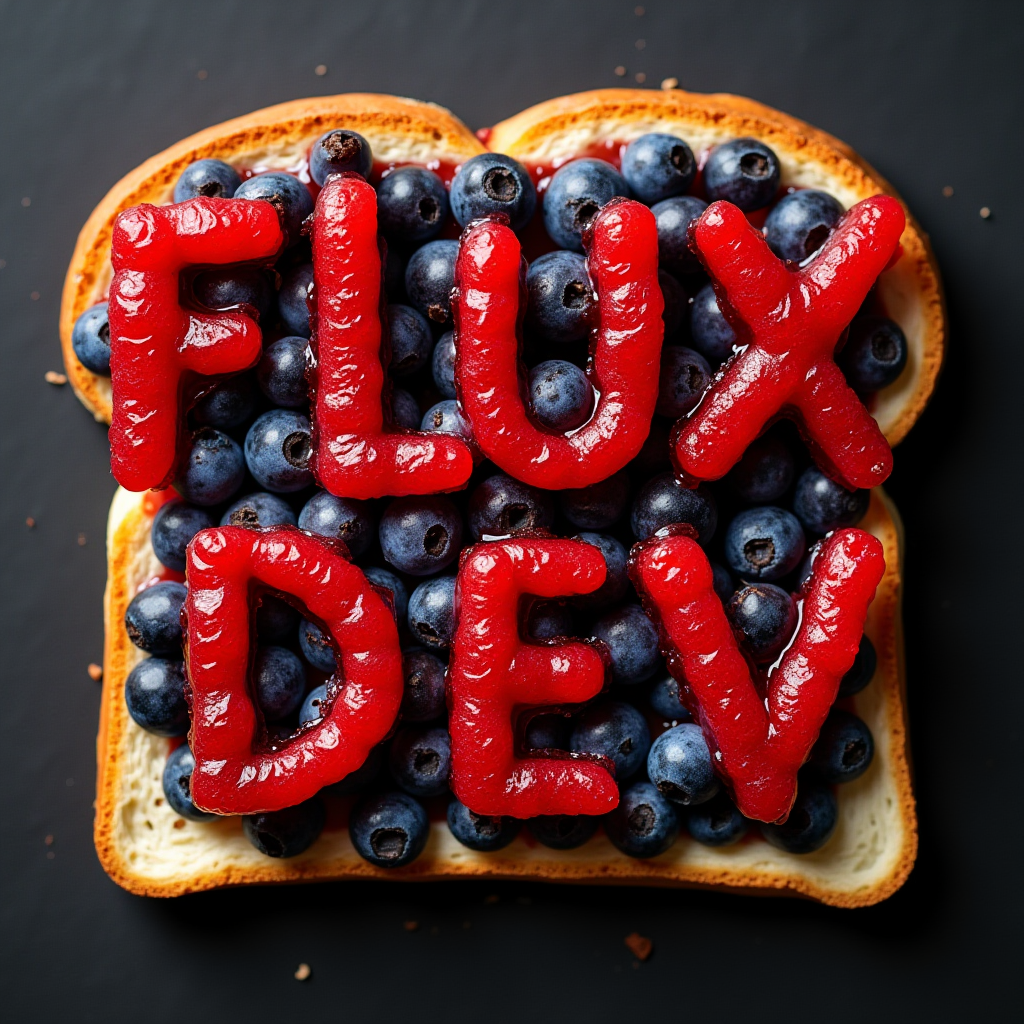

In [4]:
from IPython.display import Image, display

# 显示图像
output_path = "/content/output/1.png"
display(Image(filename=output_path))


压缩output文件夹

In [ ]:
import shutil
import os

def compress_output_folder():
    output_folder = '/content/output'
    compressed_file = '/content/output.zip'

    # 检查输出文件夹是否存在
    if not os.path.exists(output_folder):
        print("Output folder not found.")
        return

    # 压缩文件夹
    shutil.make_archive(compressed_file[:-4], 'zip', output_folder)  # 去掉.zip后缀，make_archive会自动添加

    print(f"Compressed output folder to: {compressed_file}")

# 调用函数执行压缩
compress_output_folder()

下载，或者上传到你的google drive里

In [ ]:
%cd /content
from IPython.display import FileLink
FileLink('output.zip')